# Description/How to Use

Please message Susan with any issues.

**Making sure that the code is up to date with my code**
- git remote add upstream https://github.com/susanhao/DPA_Project.git
- git remote -v
- git fetch upstream
- git checkout master
- git merge upstream/master

**Directory Setup**
- you should being using git to directly pull and push the folders Analysis and Data
- in the Data folder --> behavioral logs will go into the behavioral folder.  
 -Put the log files from google drive in the appropriate folders.  
   -download whole behavioral logs folder from google drive
 -Download the qualtrics csv from the behavioral session and put it in the correct folder.
- Once you have all the data in the Data folder up to date, you can start running this script.

**Running this Script**
- you should have jupyter notebook already installed (that's how you can view this)
- you should also have nbextensions installed
 - https://github.com/ipython-contrib/jupyter_contrib_nbextensions
 - please make sure that TOC (table of contents) is turned on
 - in the script you can press the TOC icon at the top to see the contents
- please run every cell of this script
 - you can press CTRL + SHIFT to run something
- at the end of the script, we will save our results 

**Pushing to Github**
- git add .
- git commit -m "message (ie what subject you analyzed)"
- git push -u origin master


# Setup

In [1]:
import sys
sys.path.append('../python_functions/')

from import_packages import *
from cleanup_logs import *
from matplotlib.patches import Rectangle


import gspread
from oauth2client.service_account import ServiceAccountCredentials
sns.set_style('white')
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
#put data directory here
dir_logs = '../../Data/behavioral/behavioral logs/'
dir_answer = 'answer_keys/'

raw_scores_df = pd.DataFrame()
perc_scores_df = pd.DataFrame()
task_logs = {i.split('_')[0]: i for i in os.listdir(dir_logs)}

#Put excluded/withdrawn subjs here
excluded_subjs = ['DPA_F016','DPA_F039', 'DPA_F046', 'DPA_F047', 'DPA_F050', 'DPA_F051',
                 'DPA_F057', 'DPA_F061', 'DPA_F063', 'DPA_F064', 'DPA_F069', 'DPA_F070', 'DPA_F072']

In [1]:
#basic imports
import csv
import os
import pandas as pd
import numpy as np
import re
import itertools

#visualization imports
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt


#stats imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression

#pandas stuff
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 70


# Get Task Scores

## Bhisma's Emotion Task

In [3]:
answer_df = pd.read_csv(dir_answer + 'BET_answers.csv', names =['Stim', 'Answer'])
bet_scores_df = pd.DataFrame(columns = ['BET_score_raw', 'BET_score_perc'])
#loop thru log files
for file in os.listdir(dir_logs + task_logs['BET']):
    if 'BET' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
    
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['BET'] +'/' + file, ['Stim.*', 'Final.*'])
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace everything up to the last /
            clean_log['Stim'] = clean_log['Stim'].str.replace('.*\/', '')
            clean_log['Response'] = (clean_log['Response'].str.replace('Final button press: ', '')).str.lower()

            #merge clean log and answerkeys on stim
            subj_df = clean_log.merge(answer_df, how = 'left', left_on='Stim', right_on= 'Stim')
            subj_df['Correct'] = (subj_df['Response'] == subj_df['Answer']).astype(int)

            bet_scores_df.loc[subj, 'BET'] = subj_df['Correct'].sum()
            bet_scores_df.loc[subj, 'BET_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100

raw_scores_df = bet_scores_df[['BET']]
perc_scores_df = bet_scores_df[['BET_score_perc']]

## Brad's Identity Matching

In [4]:
answer_df = pd.read_csv(dir_answer + 'Brad_shuffled_answer.csv', names =['Target', 'Stim1', 'Stim2', 'Stim3', 'Answer'])
brad_scores_df = pd.DataFrame(columns = ['brad_score_raw', 'brad_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['Brads']):
    if 'Brad' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['Brads'] +'/' + file, ['Prompt.*', 'KEYPRESSED.*'])
            #first 3 rows are practice so discard
            clean_log = clean_log.iloc[3:]
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace KEYPRESS
            clean_log['Response'] = clean_log['Response'].str.replace('KEYPRESSED: ', '')

            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.join(answer_df)
            subj_df['Correct'] = (subj_df['Response'].astype(int) == subj_df['Answer']).astype(int)

            brad_scores_df.loc[subj, 'BFMT'] = subj_df['Correct'].sum()
            brad_scores_df.loc[subj, 'brad_score_perc'] =( subj_df['Correct'].sum()/len(subj_df['Correct']))*100

raw_scores_df = raw_scores_df.join(brad_scores_df[['BFMT']], how = 'outer')
perc_scores_df = perc_scores_df.join(brad_scores_df[['brad_score_perc']], how = 'outer')

## Films Emotion Task

In [5]:
answer_df = pd.read_csv(dir_answer + 'Films_answers.csv', names =['Target', 'Stim1', 'Stim2', 'Stim3', 'Answer'])
films_scores_df = pd.DataFrame(columns = ['films_score_raw', 'films_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['films']):
    if 'Films' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['films'] +'/' + file, ['Prompt.*', 'KEYPRESSED.*'])

            #first 3 rows are practice so discard
            clean_log = clean_log.iloc[3:]
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace KEYPRESS
            clean_log['Response'] = clean_log['Response'].str.replace('KEYPRESSED: ', '')

            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.join(answer_df)
            subj_df['Correct'] = (subj_df['Response'].astype(int) == subj_df['Answer']).astype(int)

            films_scores_df.loc[subj, 'Films'] = subj_df['Correct'].sum()
            films_scores_df.loc[subj, 'films_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100

raw_scores_df = raw_scores_df.join(films_scores_df[['Films']], how = 'outer')
perc_scores_df = perc_scores_df.join(films_scores_df[['films_score_perc']], how = 'outer')

## CFMT

In [6]:
answer_df = pd.read_csv(dir_answer + 'CFMT_key.csv', names =['keypress', 'prompt'])
CFMT_scores_df = pd.DataFrame(columns = ['CFMT_score_raw', 'CFMT_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['CFMT']):
    if 'CFMT' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['CFMT'] +'/' + file, ['Prompt.*', 'Final.*'])

            #first 3 rows are practice so discard
            clean_log = clean_log.iloc[3:]
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace KEYPRESS
            clean_log['Response'] = clean_log['Response'].str.replace('Final key press: ', '')
            #replace prompt         
            clean_log['Stim'] = clean_log['Stim'].str.replace('Prompt: ', '')
            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.join(answer_df)

            subj_df['Correct'] = (subj_df['Response'].astype(int) == subj_df['prompt']).astype(int)
            CFMT_scores_df.loc[subj, 'CFMT'] = subj_df['Correct'].sum()
            CFMT_scores_df.loc[subj, 'CFMT_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100
        
raw_scores_df = raw_scores_df.join(CFMT_scores_df[['CFMT']], how = 'outer')
perc_scores_df = perc_scores_df.join(CFMT_scores_df[['CFMT_score_perc']], how = 'outer')

## Famous Faces

In [7]:
ff_scores_df = pd.DataFrame(columns = ['FF_score_raw', 'FF_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['FF']):
    if 'FF' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['FF'] +'/' + file, [ 'Prompt.*'])
            clean_log.rename({0:'Response'}, axis = 1, inplace = True)

            #replace prompt answer
            clean_log['Response'] = clean_log['Response'].str.replace('Prompt Answer: ', '')


            correct = clean_log['Response'].value_counts()['Yes! I got it right']
            if ('I got it wrong and I am familiar with this face.' in clean_log['Response'].value_counts().index):
                total_known = clean_log['Response'].value_counts()['Yes! I got it right'] + clean_log['Response'].value_counts()['I got it wrong and I am familiar with this face.']
            else:
                total_known = correct

            ff_scores_df.loc[subj, 'FF'] = (correct/total_known)*100
            ff_scores_df.loc[subj, 'FF_score_perc'] = (correct/total_known)*100

raw_scores_df = raw_scores_df.join(ff_scores_df[['FF']], how = 'outer')
perc_scores_df = perc_scores_df.join(ff_scores_df[['FF_score_perc']], how = 'outer')

## Mind in the Eyes

In [8]:
answer_df = pd.read_csv(dir_answer + 'MOE_answers.csv', names =['Target',  'Answer'])
MOE_scores_df = pd.DataFrame(columns = ['MOE_score_raw', 'MOE_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['MOE']):
    if 'MOE' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['MOE'] +'/' + file, ['Test.*', 'Final.*'])

            #first row is practice so discard
            clean_log = clean_log.iloc[1:]
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace strings
            clean_log['Stim'] = clean_log['Stim'].str.replace('Test: stims_MOE/', '')
            clean_log['Response'] = clean_log['Response'].str.replace('Final button press: ', '')

            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.join(answer_df)
            subj_df['Correct'] = (subj_df['Response'] == subj_df['Answer'])

            MOE_scores_df.loc[subj, 'MIE'] = subj_df['Correct'].sum()
            MOE_scores_df.loc[subj, 'MOE_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100
        
raw_scores_df = raw_scores_df.join(MOE_scores_df[['MIE']], how = 'outer')
perc_scores_df = perc_scores_df.join(MOE_scores_df[['MOE_score_perc']], how = 'outer')

## Emotion Hexagon

DPA_F047 isn't right - somehow didn't record everything. But we excluded them

In [9]:
answer_df = pd.read_csv(dir_answer + 'EH_answers.csv', names =['Stim',  'Emotion1', 'Emotion2', 'Answer'])
EH_scores_df = pd.DataFrame(columns = ['EH_score_raw', 'EH_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['EH']):
    if 'EH' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['EH'] +'/' + file, ['Stim.*', 'Final.*'])
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace strings
            clean_log['Stim'] = clean_log['Stim'].str.replace('Stim: stims/', '')
            clean_log['Stim'] = clean_log['Stim'].str.replace('.jpg', '')
            clean_log['Response'] = clean_log['Response'].str.replace('Final button press: ', '')
            clean_log['Response'] = clean_log['Response'].str.lower()

            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.merge(answer_df, how='left', left_on='Stim', right_on='Stim')

            #get rid of 50/50 rows - nan
            subj_df =  subj_df[~subj_df['Answer'].isna()]

    #         #comparing diff morphs
    #         morphs_90_10 = subj_df[subj_df['Emotion1'].str.contains('90') | subj_df['Emotion1'].str.contains('10')]
    #         morphs_70_30 = subj_df[subj_df['Emotion1'].str.contains('30') | subj_df['Emotion1'].str.contains('70')]
    #         morphs_90_10['Correct'] = (morphs_90_10['Response'] == morphs_90_10['Answer'])
    #         morphs_70_30['Correct'] = (morphs_70_30['Response'] == morphs_70_30['Answer'])
    #         EH_90_10.loc[subj] = morphs_90_10['Correct'].sum()/len(morphs_90_10['Correct'])
    #         EH_70_30.loc[subj] = morphs_70_30['Correct'].sum()/len(morphs_70_30['Correct'])

            subj_df['Correct'] = (subj_df['Response'] == subj_df['Answer'])
            EH_scores_df.loc[subj, 'EH'] = subj_df['Correct'].sum()
            EH_scores_df.loc[subj, 'EH_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct'])) * 100
            
raw_scores_df = raw_scores_df.join(EH_scores_df[['EH']], how = 'outer')
perc_scores_df = perc_scores_df.join(EH_scores_df[['EH_score_perc']], how = 'outer')

## CCMT

In [10]:
answer_df = pd.read_csv(dir_answer + 'CCMT_answers.csv', names =['prompt'])
CCMT_scores_df = pd.DataFrame(columns = ['CCMT_score_raw', 'CCMT_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['CFMTcars']):
    if 'CFMTcars' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['CFMTcars'] +'/' + file, ['Prompt.*', 'Final.*'])

            #first 3 rows are practice so discard
            clean_log = clean_log.iloc[3:]
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)

            #replace KEYPRESS
            clean_log['Response'] = clean_log['Response'].str.replace('Final key press: ', '')
            #replace prompt         
            clean_log['Stim'] = clean_log['Stim'].str.replace('Prompt: ', '')
            #merge  on index for clean log and answerkeys on stim
            subj_df = clean_log.set_index('Stim').join(answer_df)

            subj_df['Correct'] = (subj_df['Response'].astype(int) == subj_df['prompt']).astype(int)
            CCMT_scores_df.loc[subj, 'CCMT'] = subj_df['Correct'].sum()
            CCMT_scores_df.loc[subj, 'CCMT_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100
        
raw_scores_df = raw_scores_df.join(CCMT_scores_df[['CCMT']], how = 'outer')
perc_scores_df = perc_scores_df.join(CCMT_scores_df[['CCMT_score_perc']], how = 'outer')

## Gaze Direction

In [32]:
answer_df = pd.read_csv(dir_answer + 'GD_answers.csv', names =['Stim','Answer'])
GD_scores_df = pd.DataFrame(columns = ['GD_score_raw', 'GD_score_perc'])

#loop thru log files
for file in os.listdir(dir_logs + task_logs['GD']):
    if 'GD' in file:
        subj = re.search('DPA_F[0-9]{3}', file).group(0)
        
        if subj not in excluded_subjs:
            clean_log = cleanup_logs(dir_logs + task_logs['GD'] +'/' + file, ['Stim.*', 'Final.*'])
            clean_log.rename({0:'Stim', 1:'Response'}, axis = 1, inplace = True)
            
            #first 3 rows are practice so discard
            clean_log = clean_log.iloc[3:]

            #replace everything up to the last /
            clean_log['Stim'] = clean_log['Stim'].str.replace('.*\/', '')
            clean_log['Response'] = (clean_log['Response'].str.replace('Final button press: ', '')).str.lower()
            clean_log.drop(clean_log.index[84],inplace=True)

            #merge clean log and answerkeys on stim
            subj_df = clean_log.merge(answer_df, how = 'left', left_on='Stim', right_on= 'Stim')
            subj_df['Correct'] = (subj_df['Response'] == subj_df['Answer']).astype(int)
            
            GD_scores_df.loc[subj, 'GD'] = subj_df['Correct'].sum()
            GD_scores_df.loc[subj, 'GD_score_perc'] = (subj_df['Correct'].sum()/len(subj_df['Correct']))*100
        
raw_scores_df = raw_scores_df.join(GD_scores_df[['GD']], how = 'outer')
perc_scores_df = perc_scores_df.join(GD_scores_df[['GD_score_perc']], how = 'outer')

NameError: name 'dir_answer' is not defined

## Implicit Association Task

### Scoring

In [49]:
means_df = pd.DataFrame(columns = ['1st_race', '3_mean', '4_mean', '6_mean', '7_mean'])

for file in os.listdir('logs'):
    if 'iat' in file:
        log_df = pd.read_csv('logs/' + file, delimiter = '\t', names = ['time', 'level', 'msg'])
        data_df = log_df[log_df['level'] == 'CRITICAL ']
        data_df.drop(columns = ['level'], inplace = True)

        block = 0
        score_blocks_df = pd.DataFrame(columns = ['block', 'time', 'msg'])
        for index, row in data_df.iterrows():
            if 'Instructions' in row['msg']:
                block += 1
            if block in [3, 4, 6, 7]:
                score_blocks_df = score_blocks_df.append({'block': block, 'time': row['time'], 'msg': row['msg']}, ignore_index = True)

        score_blocks_df = score_blocks_df[~score_blocks_df['msg'].str.contains('Block')]

        score_blocks_df['end_time'] = score_blocks_df['time'].shift(-1)
        score_blocks_df.rename(columns = {'time': 'start_time'}, inplace = True)
        score_blocks_df = score_blocks_df[~score_blocks_df['msg'].str.contains('keypress')]

        score_blocks_df['time_diff'] = score_blocks_df['end_time'] - score_blocks_df['start_time']
        score_blocks_df['time_diff'][(score_blocks_df['time_diff'] <= 0.3) | (score_blocks_df['time_diff'] >= 10)] = np.nan

        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            #display(score_blocks_df[np.isnan(score_blocks_df['time_diff'])])
            #display(score_blocks_df)
        
        means_df.loc[file[8:12], '1st_race'] = file[13:18]
        means_df.loc[file[8:12], '3_mean'] = score_blocks_df[score_blocks_df['block'] == 3]['time_diff'].mean()
        means_df.loc[file[8:12], '4_mean'] = score_blocks_df[score_blocks_df['block'] == 4]['time_diff'].mean()
        means_df.loc[file[8:12], '6_mean'] = score_blocks_df[score_blocks_df['block'] == 6]['time_diff'].mean()
        means_df.loc[file[8:12], '7_mean'] = score_blocks_df[score_blocks_df['block'] == 7]['time_diff'].mean()
        means_df.loc[file[8:12], '3_6_SD'] = score_blocks_df[(score_blocks_df['block'] == 3) |
                                                            (score_blocks_df['block'] == 6)]['time_diff'].std()
        means_df.loc[file[8:12], '4_7_SD'] = score_blocks_df[(score_blocks_df['block'] == 4) |
                                                            (score_blocks_df['block'] == 7)]['time_diff'].std()
        
        #dividing based on race of stimulus
        b_stim_df = score_blocks_df[score_blocks_df['msg'].str.contains('b') & score_blocks_df['msg'].str.contains('jpg')]
        #display(b_stim_df)
        b_3_mean = b_stim_df[b_stim_df['block'] == 3]['time_diff'].mean()
        b_4_mean = b_stim_df[b_stim_df['block'] == 4]['time_diff'].mean()
        b_6_mean = b_stim_df[b_stim_df['block'] == 6]['time_diff'].mean()
        b_7_mean = b_stim_df[b_stim_df['block'] == 7]['time_diff'].mean()
        b_3_6_SD = b_stim_df[(b_stim_df['block'] == 3) | (b_stim_df['block'] == 6)]['time_diff'].std()
        b_4_7_SD = b_stim_df[(b_stim_df['block'] == 4) | (b_stim_df['block'] == 7)]['time_diff'].std()
        means_df.loc[file[8:12], 'b_stim_score'] = (((b_6_mean-b_3_mean)/b_3_6_SD)+((b_7_mean-b_4_mean)/b_4_7_SD))/2

        w_stim_df = score_blocks_df[score_blocks_df['msg'].str.contains('w') & score_blocks_df['msg'].str.contains('jpg')]
        #display(w_stim_df)
        w_3_mean = w_stim_df[w_stim_df['block'] == 3]['time_diff'].mean()
        w_4_mean = w_stim_df[w_stim_df['block'] == 4]['time_diff'].mean()
        w_6_mean = w_stim_df[w_stim_df['block'] == 6]['time_diff'].mean()
        w_7_mean = w_stim_df[w_stim_df['block'] == 7]['time_diff'].mean()
        w_3_6_SD = w_stim_df[(w_stim_df['block'] == 3) | (w_stim_df['block'] == 6)]['time_diff'].std()
        w_4_7_SD = w_stim_df[(w_stim_df['block'] == 4) | (w_stim_df['block'] == 7)]['time_diff'].std()
        means_df.loc[file[8:12], 'w_stim_score'] = (((w_6_mean-w_3_mean)/w_3_6_SD)+((w_7_mean-w_4_mean)/w_4_7_SD))/2

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   # display(means_df)

In [44]:
means_df['final_score'] = (((means_df['6_mean']-means_df['3_mean'])/means_df['3_6_SD'])+((means_df['7_mean']-means_df['4_mean'])/means_df['4_7_SD']))/2

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(means_df)
    
for index, row in means_df.iterrows():
    if row['1st_race'] == 'black':
        means_df.loc[index, 'final_score'] = means_df.loc[index, 'final_score'] * -1
        means_df.loc[index, 'b_stim_score'] = means_df.loc[index, 'b_stim_score'] * -1
        means_df.loc[index, 'w_stim_score'] = means_df.loc[index, 'w_stim_score'] * -1
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(means_df)

,1st_race,3_mean,4_mean,6_mean,7_mean,3_6_SD,4_7_SD,b_stim_score,w_stim_score,final_score
F020,black,0.72996,0.66417,0.563335,0.60961,0.225582,0.144739,1.024093,0.712659,0.557799
F054,white,0.60336,0.585883,0.642565,0.662988,0.159130,0.165632,0.080297,-0.195357,0.355945
F043,white,0.886045,0.777628,0.810145,0.787588,0.344372,0.249856,-0.208697,-0.584575,-0.090269
F033,black,0.876025,0.729272,0.851865,0.7989,0.380667,0.213228,0.038728,-0.356878,-0.131536
F037,white,0.85104,0.762208,0.891025,0.887295,0.401535,0.375076,-0.282408,0.524444,0.21654
F024,white,0.68092,0.745562,0.81934,0.768893,0.201449,0.269836,1.021407,0.443889,0.38679
F034,white,0.623405,0.59961,0.644195,0.647165,0.171061,0.148035,0.153925,-0.017075,0.221389
F044,black,0.87687,0.778042,0.624205,0.670055,0.238150,0.213421,0.777119,1.049246,0.783466
F053,black,2.07525,1.290113,1.52153,1.192542,1.488037,0.852737,0.470231,-0.320718,0.243267
F023,black,0.97362,0.804743,0.866055,0.728872,0.272918,0.268543,0.516278,0.187630,0.338327


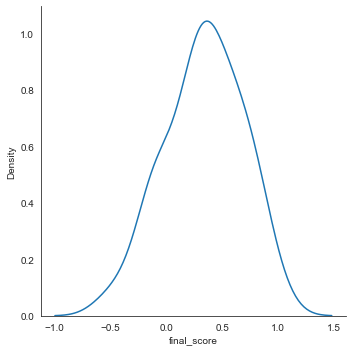

In [18]:
sns.displot(data = means_df, x = "final_score", kind = 'kde')

### Order Effect

Ttest_indResult(statistic=-1.1601847206252378, pvalue=0.253026806792546)
MannwhitneyuResult(statistic=168.0, pvalue=0.13953650325004135)


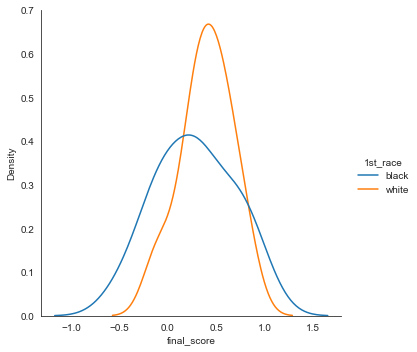

In [6]:
#comparing black_1st and white_1st
import scipy
black_1st_scores = means_df[means_df['1st_race'] == 'black']['final_score']
white_1st_scores = means_df[means_df['1st_race'] == 'white']['final_score']

order_ttest = scipy.stats.ttest_ind(black_1st_scores, white_1st_scores)
print(order_ttest)

order_mannwhitneyu = scipy.stats.mannwhitneyu(black_1st_scores, white_1st_scores)
print(order_mannwhitneyu)

means_df['final_score'] = means_df['final_score'].astype('float64')
sns.displot(data = means_df, x = "final_score", hue = '1st_race', kind = 'kde')

### Demographics

In [5]:
#importing demographics
demographics_df = pd.read_excel('DPA_demographics.xlsx')
demographics_df = demographics_df.set_index('subj')
demo_scores_df = pd.concat([demographics_df, means_df['final_score']], axis = 1)
demo_scores_df['abs_score'] = abs(demo_scores_df['final_score'])
display(demo_scores_df)

,Age,Gender,Hispanic,Race,Subcategory,final_score,abs_score
F020,21,M,no,Asian,NaN,0.557799,0.557799
F023,20,F,no,White,NaN,0.338327,0.338327
F024,30,M,no,Asian,East Asian,0.386790,0.386790
F025,34,M,no,White,NaN,0.356228,0.356228
F027,21,F,no,Asian,Southeast Asian,0.130399,0.130399
F028,23,M,no,Asian,East Asian,0.516335,0.516335
F029,20,M,no,White,NaN,0.988123,0.988123
F030,19,M,yes,White,NaN,0.199459,0.199459
F031,20,M,no,Asian,Indian/Pakistani/South Asian,0.084047,0.084047
F032,37,M,no,White,NaN,0.611849,0.611849


### Gender

<AxesSubplot:ylabel='Gender'>

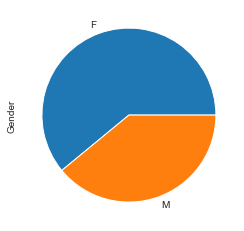

In [7]:
#pie chart
demo_scores_df.Gender.value_counts().plot(kind = 'pie')

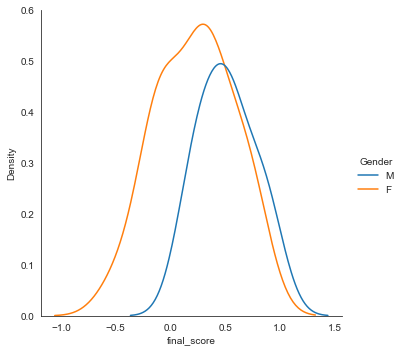

In [8]:
sns.displot(data = demo_scores_df, x = "final_score", hue = 'Gender', kind = 'kde')

Ttest_indResult(statistic=2.847401856414154, pvalue=0.00699685316152866)
MannwhitneyuResult(statistic=104.0, pvalue=0.005350027517806919)


<AxesSubplot:xlabel='Gender', ylabel='final_score'>

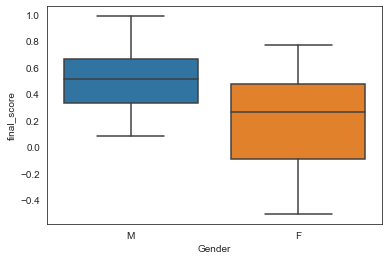

In [9]:
#gender and final score
M_scores = demo_scores_df[demo_scores_df['Gender'] == 'M']['final_score']
F_scores = demo_scores_df[demo_scores_df['Gender'] == 'F']['final_score']

gender_ttest = scipy.stats.ttest_ind(M_scores, F_scores)
print(gender_ttest)

gender_mannwhitneyu = scipy.stats.mannwhitneyu(M_scores, F_scores)
print(gender_mannwhitneyu)

sns.boxplot(x = 'Gender', y = 'final_score', data = demo_scores_df)

Ttest_indResult(statistic=2.222773473575398, pvalue=0.03209802372027642)
MannwhitneyuResult(statistic=120.0, pvalue=0.016804704874817267)


<AxesSubplot:xlabel='Gender', ylabel='abs_score'>

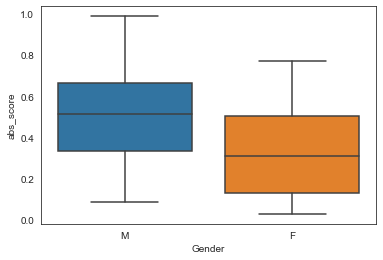

In [10]:
#gender and abs value of final score
M_abs_scores = demo_scores_df[demo_scores_df['Gender'] == 'M']['abs_score']
F_abs_scores = demo_scores_df[demo_scores_df['Gender'] == 'F']['abs_score']

gender_abs_ttest = scipy.stats.ttest_ind(M_abs_scores, F_abs_scores)
print(gender_abs_ttest)

gender_abs_mannwhitneyu = scipy.stats.mannwhitneyu(M_abs_scores, F_abs_scores)
print(gender_abs_mannwhitneyu)

sns.boxplot(x = 'Gender', y = 'abs_score', data = demo_scores_df)

### Age

Pearson correlation results:(0.004195687733213032, 0.9792296055108064)


<AxesSubplot:xlabel='Age', ylabel='final_score'>

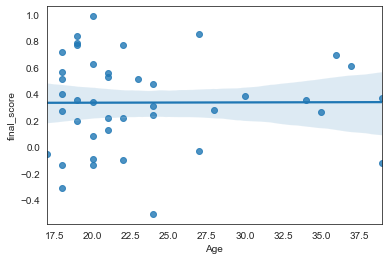

In [20]:
#age and final score
age_score_corr = scipy.stats.pearsonr(demo_scores_df['Age'], demo_scores_df['final_score'])
print('Pearson correlation results:' + str(age_score_corr))

sns.regplot(x = 'Age', y = 'final_score', data = demo_scores_df)

Pearson correlation results:(-0.034078027515803015, 0.8324822485071772)


<AxesSubplot:xlabel='Age', ylabel='abs_score'>

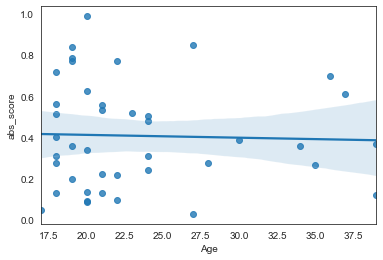

In [21]:
#age and abs value of final score
age_absscore_corr = scipy.stats.pearsonr(demo_scores_df['Age'], demo_scores_df['abs_score'])
print('Pearson correlation results:' + str(age_absscore_corr))

sns.regplot(x = 'Age', y = 'abs_score', data = demo_scores_df)

### Black vs White Stimuli

Ttest_indResult(statistic=-0.34483526539996406, pvalue=0.7311231603679358)
MannwhitneyuResult(statistic=803.0, pvalue=0.3657471355883092)


<AxesSubplot:xlabel='b_stim_score', ylabel='Density'>

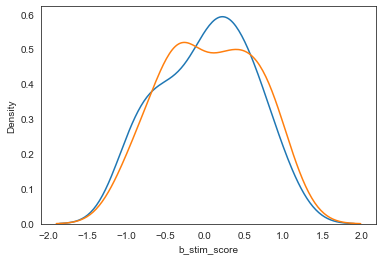

In [51]:
stim_race_ttest = scipy.stats.ttest_ind(means_df['b_stim_score'], means_df['w_stim_score'])
print(stim_race_ttest)

stim_race_mannwhitneyu = scipy.stats.mannwhitneyu(means_df['b_stim_score'], means_df['w_stim_score'])
print(stim_race_mannwhitneyu)

sns.kdeplot(data = means_df, x = "b_stim_score")
sns.kdeplot(data = means_df, x = "w_stim_score")

## Online

In [12]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
         '../online/DPAProject-083039688e6a.json', scope) # Your json file here

gc = gspread.authorize(credentials)
wks = gc.open("Subject Log").sheet1

data = wks.get_all_values()
headers = data.pop(0)

df_subj_qual = pd.DataFrame(data, columns=headers)

In [13]:
wks = gc.open("Subject Log").worksheets()[1]

data = wks.get_all_values()
headers = data.pop(0)

df_online = pd.DataFrame(data, columns=headers)

In [14]:
all_subjs = df_subj_qual[df_subj_qual['Date Finished'] == ""]["Subject ID"]
all_subjs_df = df_online[df_online['Subject ID'].isin(all_subjs)]

In [15]:
raw_scores_df = raw_scores_df.join(all_subjs_df.set_index('Subject ID')[['AQ Score', 'EQ Score', 'STAI Y1', 'STAI Y2', 'CFMT - Australian', 'PI 20']])
raw_scores_df = raw_scores_df.replace('-', np.nan)
raw_scores_df = raw_scores_df.replace('', np.nan)
raw_scores_df = raw_scores_df.astype(float)
raw_scores_df.rename(columns ={'AQ Score': 'AQ', 'EQ Score': 'EQ', 'STAI Y1': 'STAI_Y1', 'STAI Y2': 'STAI_Y2', 'CFMT - Australian': 'CFMT_aus', 'PI 20': 'PI20'}, inplace=True)

## Export

In [16]:
raw_scores_df.to_csv('results/raw_scores_32220.csv')
perc_scores_df.to_csv('results/perc_scores_32220.csv')

# Analysis

## Factor Analysis

In [17]:
from factor_analyzer import FactorAnalyzer
x_factor = raw_scores_df.loc[:, :'GD'].join(raw_scores_df['CFMT_aus'])
fa = FactorAnalyzer(rotation=None)
fa.fit(x_factor)

ModuleNotFoundError: No module named 'factor_analyzer'

In [ ]:
eig, v = fa.get_eigenvalues()
plt.scatter(range(0, len(eig)), eig)
plt.plot(range(0, len(eig)), eig)

In [ ]:
fa = FactorAnalyzer(rotation='promax', n_factors =4)
fa.fit(x_factor)

In [ ]:
factor_df = pd.DataFrame(index = x_factor.columns, columns = ['factor1', 'factor2', 'factor3', 'factor4'], data = fa.loadings_)
# factor_df.reindex(['CFMT', 'CFMT_aus', 'BFMT', 'FF', 'CCMT', 'BET', 'EH', 'MIE', 'Films', 'GD'])

In [ ]:
def label_point_from_df(x_label, y_label, df, ax):
    texts = []
    for i, point in df.iterrows():
        texts.append(ax.text(point[x_label], point[y_label], point.name))
    adjust_text(texts)

In [ ]:
from adjustText import adjust_text


plt.rcParams.update({'font.size': 13})
ax = sns.scatterplot(x= 'factor1', y='factor2', data = factor_df)
label_point_from_df('factor1', 'factor2', factor_df, ax)

In [ ]:
plt.rcParams.update({'font.size': 13})
ax = sns.scatterplot(x= 'factor2', y='factor3', data = factor_df)
label_point_from_df('factor2', 'factor3', factor_df, ax)

In [ ]:
plt.rcParams.update({'font.size': 13})
ax = sns.scatterplot(x= 'factor3', y='factor4', data = factor_df)
label_point_from_df('factor3', 'factor4', factor_df, ax)

In [ ]:
transform_df = pd.DataFrame(index = x_factor.index, columns = ['factor1', 'factor2', 'factor3', 'factor4'], data = fa.transform(x_factor))
transform_df = transform_df.join(raw_scores_df[['AQ', 'EQ', 'STAI_Y1', 'STAI_Y2']])

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(transform_df.corr(), annot=True)

In [ ]:
# p_values = calculate_pvalues(transform_df.astype(float)).values

perm_pvalue = []
transform_df = transform_df.astype(float)
for col_1 in transform_df.columns:
    row_pvalue = []
    for col_2 in transform_df.columns:
        print(col_1, col_2)
        perm_df = permutation_test(transform_df, col_1, col_2, 1000)
        corr_par = transform_df[[col_1, col_2]].corr().iloc[0, 1]
        row_pvalue.append(np.sum(np.abs(perm_df['perm_corr']) > np.abs(corr_par))/1000)
    perm_pvalue.append(row_pvalue)
        

In [ ]:
pvalues_df = pd.DataFrame(perm_pvalue, columns = transform_df.columns, index = transform_df.columns)

In [ ]:
plt.figure(figsize=(15, 15))
p_values_df = pvalues_df.loc[transform_df.columns, transform_df.columns]
labels =transform_df.columns

# mask = np.triu(np.ones_like(transform_df.astype(float).corr(), dtype=np.bool))
# ax = sns.heatmap(transform_df.astype(float).corr(), mask=mask, annot = True, cmap = 'RdBu', xticklabels=labels, yticklabels=labels)
ax = sns.heatmap(transform_df.astype(float).corr(), annot = True, cmap = 'RdBu_r', xticklabels=labels, yticklabels=labels)
for y_i, row in enumerate(p_values_df.values):
    for x_i, cell in enumerate(row):
        if cell < 0.05:
            ax.add_patch(Rectangle((x_i, y_i), 1, 1, fill=False, edgecolor = 'black', lw=3))
plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca_df = x_factor
D = pca_df.values
pca_n = D.shape[0]
#Center Data
pca_means = np.mean(D, axis = 0)
X = (D - pca_means)/np.sqrt(pca_n)

pca = PCA()
pcs = pca.fit_transform(X)

In [ ]:
pca_df['pc1'] = pcs[:, 0]
pca_df['pc2'] = pcs[:, 1]
pca_df['pc3'] = pcs[:, 2]

In [ ]:
features_df = pd.DataFrame(columns = ['pc1', 'pc2', 'pc3'], index=pca_df.columns[:-3])
t_features = pca.components_.T * np.sqrt(pca.explained_variance_)
features_df['pc1'] = t_features[:, 0]
features_df['pc2'] = t_features[:, 1]
features_df['pc3'] = t_features[:, 2]




In [ ]:
from adjustText import adjust_text


plt.rcParams.update({'font.size': 13})
ax = sns.scatterplot(x= 'pc1', y='pc2', data = features_df)
label_point_from_df('pc1', 'pc2', features_df, ax)

In [ ]:
plt.rcParams.update({'font.size': 13})
ax = sns.scatterplot(x= 'pc2', y='pc3', data = features_df)
label_point_from_df('pc2', 'pc3', features_df, ax)

In [ ]:
pca_df.join(raw_scores_df[['AQ', 'EQ', 'STAI_Y1', 'STAI_Y2']]).loc[:, 'pc1':].corr().round(2)

## Correlations

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [ ]:
from sklearn.utils import shuffle


def permutation_test(df, y, x, times_shuffle):
    np.random.seed(1000)
    perm_df = pd.DataFrame()
    for i in range(times_shuffle):
        y_shuffle = shuffle(df[y]).reset_index(drop=True)
        shuffle_df = df[[x]].reset_index(drop=True)
        shuffle_df[y] = y_shuffle

        corr = shuffle_df[[y, x]].corr().iloc[0, 1]
        perm_df.loc[i, 'perm_corr'] = corr
    return perm_df

In [ ]:
# p_values = calculate_pvalues(raw_scores_df.astype(float)).values

perm_pvalue = []
raw_scores_df = raw_scores_df.astype(float)
for col_1 in raw_scores_df.columns:
    row_pvalue = []
    for col_2 in raw_scores_df.columns:
        print(col_1, col_2)
        perm_df = permutation_test(raw_scores_df, col_1, col_2, 1000)
        corr_par = raw_scores_df[[col_1, col_2]].corr().iloc[0, 1]
        row_pvalue.append(np.sum(np.abs(perm_df['perm_corr']) > np.abs(corr_par))/1000)
    perm_pvalue.append(row_pvalue)
        

In [ ]:
pvalues_df = pd.DataFrame(perm_pvalue, columns = raw_scores_df.columns, index = raw_scores_df.columns)

In [ ]:
plt.figure(figsize=(15, 15))
raw_scores_df = raw_scores_df[['CFMT', 'CFMT_aus', 'BFMT', 'FF', 'CCMT', 'PI20', 'BET', 'EH', 'MIE', 'Films', 'GD', 'AQ', 'EQ', 'STAI_Y1', 'STAI_Y2']]
p_values_df = pvalues_df.loc[raw_scores_df.columns, raw_scores_df.columns]
labels = ['CFMT', 'CFMT Australian', 'Brads FMT', 'Famous Faces', 'CCMT', 'PI20', 'Bhismas Emotion Task', 'Emotion Hexagon', 'Mind in the Eyes', 'Films Task', 'Gaze Direction', 'AQ', 'EQ', 'STAI_Y1', 'STAI_Y2']

# mask = np.triu(np.ones_like(raw_scores_df.astype(float).corr(), dtype=np.bool))
# ax = sns.heatmap(raw_scores_df.astype(float).corr(), mask=mask, annot = True, cmap = 'RdBu', xticklabels=labels, yticklabels=labels)
ax = sns.heatmap(raw_scores_df.astype(float).corr(), annot = True, cmap = 'RdBu_r', xticklabels=labels, yticklabels=labels)
for y_i, row in enumerate(p_values_df.values):
    for x_i, cell in enumerate(row):
        if cell < 0.05:
            ax.add_patch(Rectangle((x_i, y_i), 1, 1, fill=False, edgecolor = 'black', lw=3))
plt.show()

In [ ]:
sns.regplot(x = 'AQ', y = 'CFMT_aus', data = raw_scores_df.astype(float))
print (pearsonr(raw_scores_df['AQ'].astype(float), raw_scores_df['CFMT_aus'].astype(float)))

In [ ]:
sns.regplot(x = 'STAI_Y2', y = 'CFMT_aus', data = raw_scores_df.astype(float))
print (pearsonr(raw_scores_df['STAI_Y2'].astype(float), raw_scores_df['CFMT'].astype(float)))

In [ ]:
p_values = calculate_pvalues(raw_scores_df.astype(float)).values
pd.DataFrame(data= p_values)

## Histograms

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.set_figwidth(30)
fig.set_figheight(20)
ax = ax.ravel()
for i, col in enumerate(raw_scores_df.columns):
    ax[i].hist(raw_scores_df[col], bins=10)
    ax[i].set_title(col)